In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [13]:
# Loading Data
source = 'main.csv'
df = pd.read_csv(source, low_memory=False)

In [14]:
# column names normalization
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("(", "").str.replace(")", "")

In [15]:
# datetime conversion
df['service_start_date'] = pd.to_datetime(df['service_start_date'], errors='coerce')
df['service_end_date'] = pd.to_datetime(df['service_end_date'], errors='coerce')
df['revenue_month'] = pd.to_datetime(df['revenue_month'], format='%Y-%m', errors='coerce')


# Extract year and month for easier grouping
df['year'] = df['revenue_month'].dt.year
df['month'] = df['revenue_month'].dt.month
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                'Spring' if x in [3, 4, 5] else
                                'Summer' if x in [6, 7, 8] else 'Fall')


In [16]:
# Data Cleaning, Drop rows with NaN in key columns
df_clean = df.dropna(subset=['revenue_month', 'current_charges', 'consumption_kwh'])

In [17]:
# Check total number of records per year
yearly_counts = df_clean.groupby('year').size()
print(yearly_counts)

year
2010    29268
2012    35207
2013    38534
2014    39838
2015    40499
2016    40792
2017    38489
2019    38801
2020    54391
2021    41367
2022    41435
2023    41197
2024    41217
dtype: int64


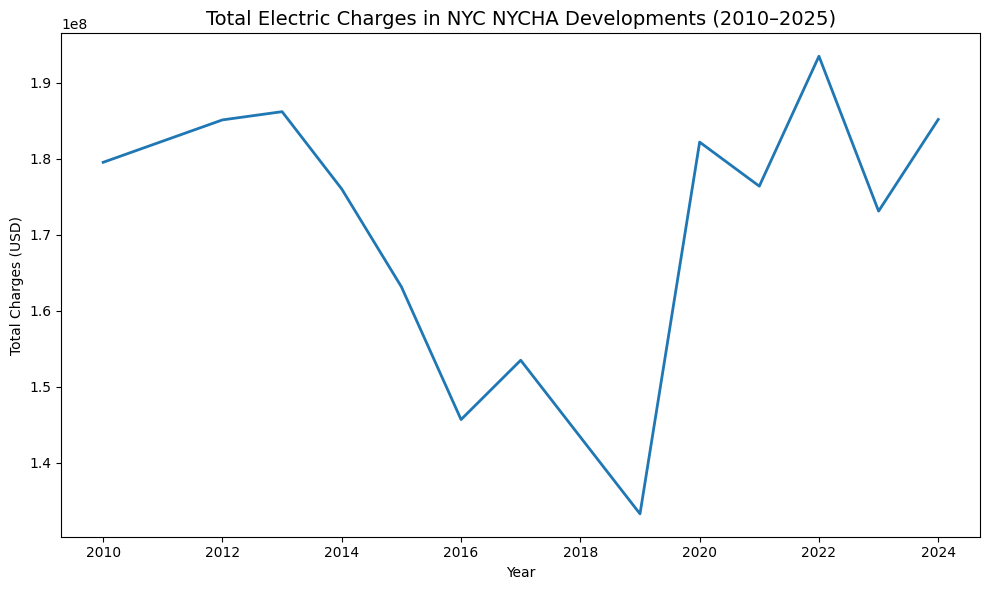

In [18]:
nyc_yearly_costs = df_clean.groupby('year')['current_charges'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(nyc_yearly_costs['year'], nyc_yearly_costs['current_charges'], linewidth=2)
plt.title('Total Electric Charges in NYC NYCHA Developments (2010–2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Total Charges (USD)')
plt.tight_layout()
plt.show()

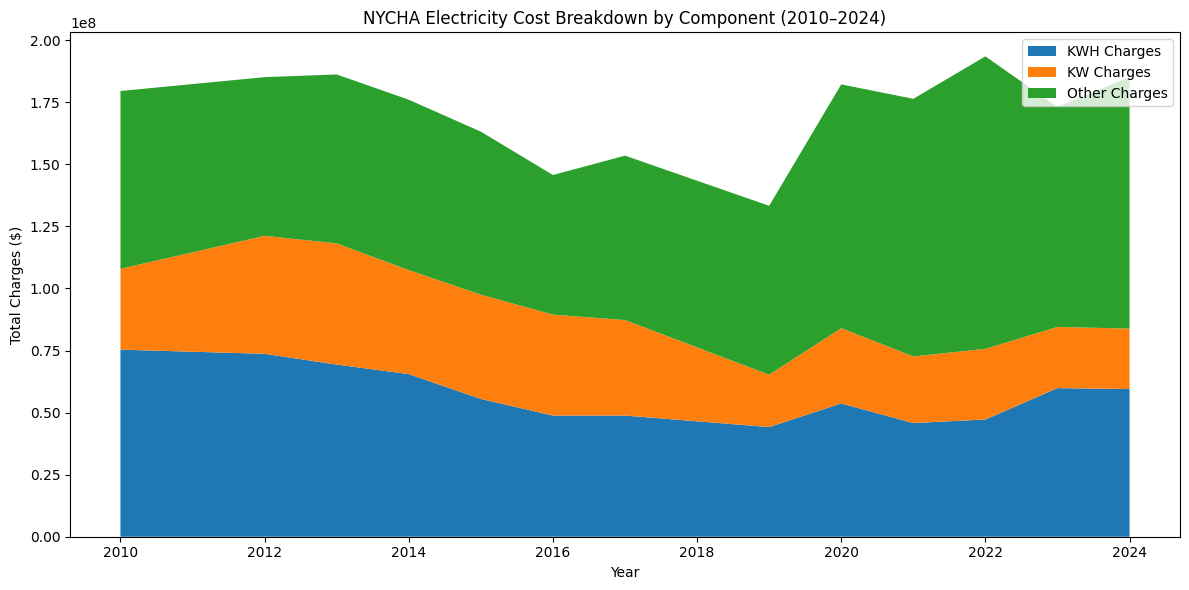

In [20]:
# Aggregate cost components by year
components = df_clean.groupby('year')[['kwh_charges', 'kw_charges', 'other_charges']].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.stackplot(
    components['year'],  # Corrected column name
    components['kwh_charges'],  # Corrected column name
    components['kw_charges'],  # Corrected column name
    components['other_charges'],  # Corrected column name
    labels=['KWH Charges', 'KW Charges', 'Other Charges']
)

plt.title('NYCHA Electricity Cost Breakdown by Component (2010–2024)')
plt.xlabel('Year')
plt.ylabel('Total Charges ($)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

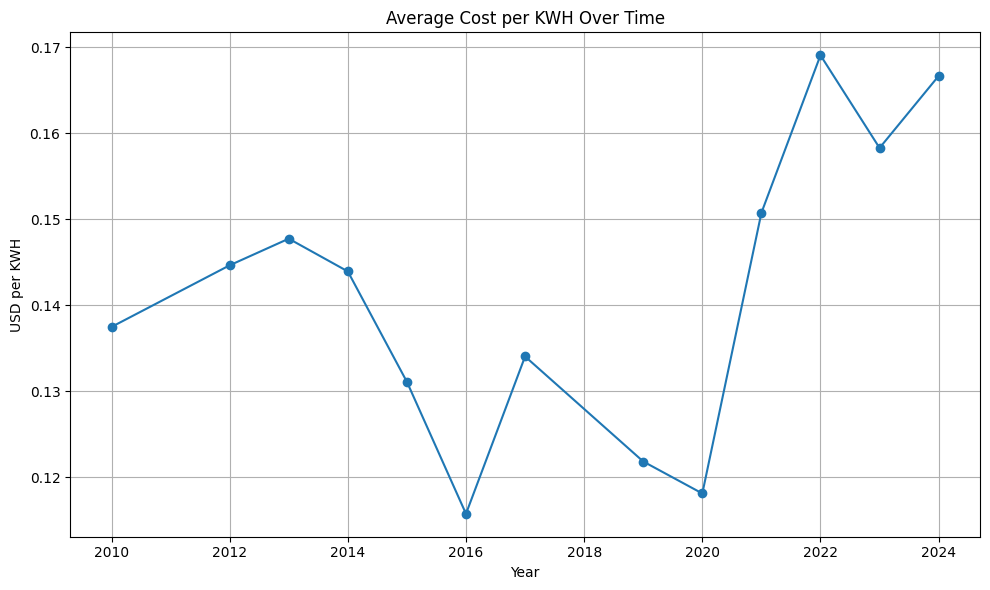

In [19]:
yearly_data = df_clean.groupby('year').agg({
    'current_charges': 'sum',
    'consumption_kwh': 'sum'
}).reset_index()

# Calculate average cost per KWH
yearly_data['avg_cost_per_kwh'] = yearly_data['current_charges'] / yearly_data['consumption_kwh']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(yearly_data['year'], yearly_data['avg_cost_per_kwh'], marker='o')
plt.title('Average Cost per KWH Over Time')
plt.xlabel('Year')
plt.ylabel('USD per KWH')
plt.grid(True)
plt.tight_layout()
plt.show()

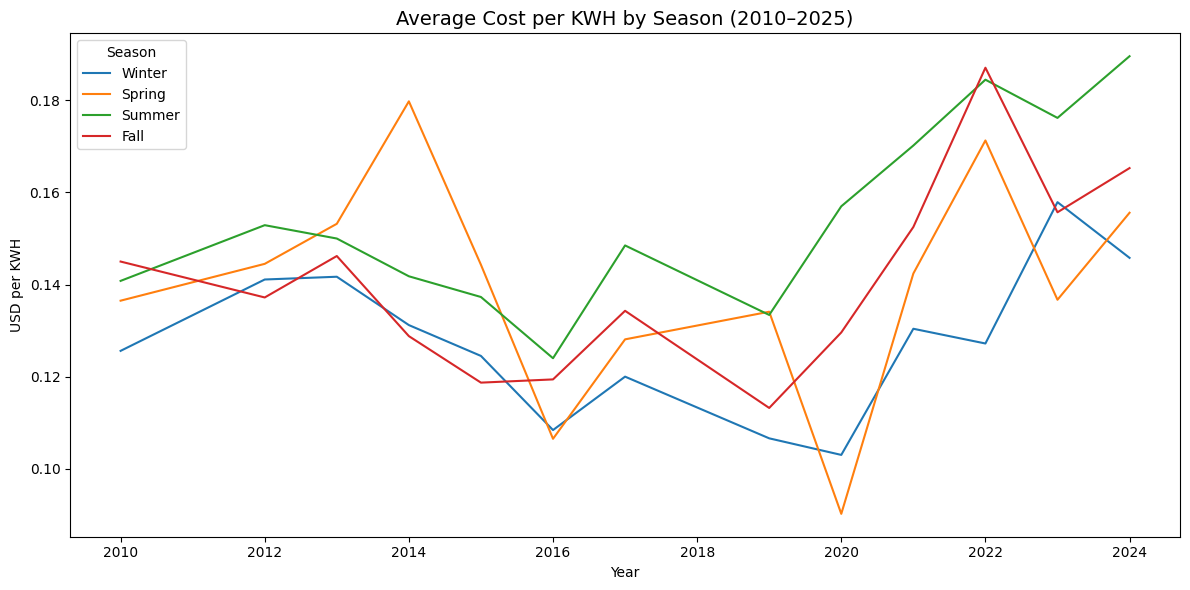

In [21]:
seasonal_avg = df.groupby(['year', 'season']).agg({
    'current_charges': 'sum',
    'consumption_kwh': 'sum'
}).reset_index()

seasonal_avg['avg_cost_per_kwh'] = (seasonal_avg['current_charges'] / seasonal_avg['consumption_kwh']).round(4)

# Pivot table for plotting
pivot_table = seasonal_avg.pivot(index='year', columns='season', values='avg_cost_per_kwh').sort_index()

# Plotting the seasonal trends
plt.figure(figsize=(12, 6))
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    if season in pivot_table.columns:
        plt.plot(pivot_table.index, pivot_table[season], label=season)

plt.title('Average Cost per KWH by Season (2010–2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('USD per KWH')
plt.legend(title='Season')
plt.tight_layout()
plt.show()

In [22]:
df_clean.to_csv('cleaned_data.csv', index=False)